In [11]:
def reconstruction_replacement(value, hook, autoencoder):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    return reconstruction

def reconstruction_no_outliers(value, hook, autoencoder, outliers):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    # Replace outliers with original values
    reconstruction[:, :, outliers] = value[:, :, outliers]
    return reconstruction

def find_outliers(dataset, cache_name, model, num_outlier_dims=2):
    device = model.cfg.device
    batch_size = 32
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        # Just take the first batch
        first_batch = next(iter(dl))
        _, cache = model.run_with_cache(first_batch.to(device))
        layer_activations = rearrange(cache[cache_name], "b s h -> (b s) h").cpu()
        outlier_dims = layer_activations.abs().max(0).values.topk(num_outlier_dims).indices
    return outlier_dims

def get_original_perplexity(model, dataset):
    total_loss = 0
    batch_size = 32
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            loss = model(batch.to(device), return_type="loss")
            total_loss += loss.item()
        # Average
        avg_neg_log_likelihood = total_loss / len(dl)

        # Convert to tensor
        avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

        # Exponentiate to compute perplexity
        perplexity = torch.exp(avg_neg_log_likelihood)
        print(f"Perplexity for original model: {perplexity.item():.2f}")
    return perplexity.item()

def get_perplexity(autoencoder, model, dataset, forward_hook):
    device = model.cfg.device
    model = model.eval()
    batch_size = 32
    autoencoder.to_device(device)
    total_loss = 0
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            loss = model.run_with_hooks(
                batch.to(device), 
                return_type="loss",
                fwd_hooks=[forward_hook]
                )
            total_loss += loss.item()
    # Average
    avg_neg_log_likelihood = total_loss / len(dl)

    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

    # Exponentiate to compute perplexity
    perplexity = torch.exp(avg_neg_log_likelihood)
    print(f"Perplexity {perplexity.item():.2f}")
    return perplexity.item()

def download_dataset(dataset_name, max_length=256, num_datapoints=None):
    dataset = load_dataset(dataset_name, split="train")
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text).map(
        lambda x: model.tokenizer(x['text']),
        batched=True,
    ).filter(
        lambda x: len(x['input_ids']) > max_length
    ).map(
        lambda x: {'input_ids': x['input_ids'][:max_length]}
    )
    return dataset

In [2]:
#Change these settings to load the correct autoencoder
from transformer_lens import HookedTransformer
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
layer = 2
setting = "residual"
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
else:
    raise NotImplementedError
gpt2_autoencoders = torch.load("/mnt/ssd-cluster/gpt2small/tied_residual_l2_r8/_31/learned_dicts.pt")
pythia_autoencoders = torch.load("/mnt/ssd-cluster/longrun2408/tied_residual_l2_r6/_31/learned_dicts.pt")

/home/mchorse/logan/t/logan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
all_the_aes = [gpt2_autoencoders, pythia_autoencoders]
models = ["gpt2", "EleutherAI/pythia-70m-deduped"]
all_model_perplexities2 = []
all_model_original_perplexities = []
all_model_l1s = []
for i, model_name in enumerate(models):
    model = HookedTransformer.from_pretrained(model_name, device=device)
    all_autoencoders = all_the_aes[i]
    # Get dataset
    dataset = download_dataset("NeelNanda/pile-10k", max_length=256, num_datapoints=100)
    # Get top-N outlier dims
    outlier_dims = find_outliers(dataset, cache_name, model, num_outlier_dims=2)
    # Get original model perplexity 
    original_perplexity = get_original_perplexity(model, dataset)
    # Get perplexity for all autoencoders
    
    num_autoencoders = len(all_autoencoders)
    all_perplexities = np.zeros(num_autoencoders)
    for i, (autoencoder, hyperparam) in enumerate(all_autoencoders):
        forward_hook = (cache_name, partial(reconstruction_no_outliers, autoencoder=autoencoder, outliers = outlier_dims))
        # forward_hook = (cache_name, partial(reconstruction_replacement, autoencoder=autoencoder))
        all_perplexities[i] = get_perplexity(autoencoder, model, dataset, forward_hook)

    all_model_original_perplexities.append(original_perplexity)
    all_model_perplexities2.append(all_perplexities)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-3fdc5f8176a0d569.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-fe8c1d66ae63294c.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7

Perplexity for original model: 27.56
Perplexity 27.60
Perplexity 27.61
Perplexity 27.65
Perplexity 27.97
Perplexity 28.64
Perplexity 30.66
Perplexity 32.77
Perplexity 39.18
Perplexity 77.80


Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-6814e00ee585e5e7.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-95d5ac1abb14d087.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7

Perplexity for original model: 27.52
Perplexity 27.51
Perplexity 27.76
Perplexity 28.43
Perplexity 31.45
Perplexity 41.50
Perplexity 61.40
Perplexity 99.80
Perplexity 300.33
Perplexity 4183.59


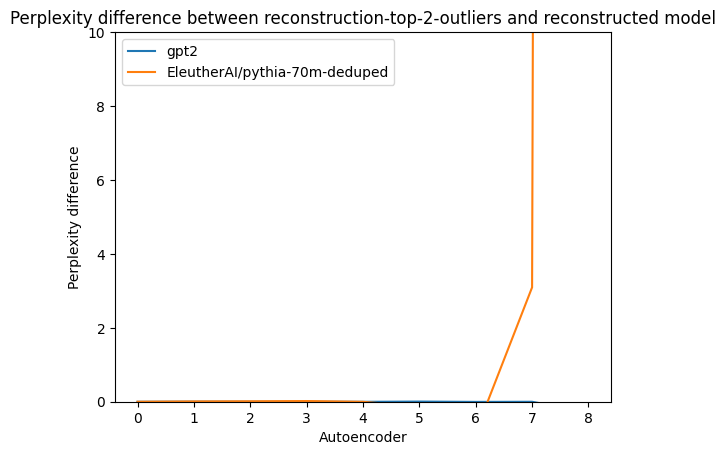

In [33]:
#Plot all_model_perplexities - all_model_perplexities2
import matplotlib.pyplot as plt
model_perplexity_diff = np.array(all_model_perplexities) - np.array(all_model_perplexities2)
plt.plot(model_perplexity_diff.T)
plt.legend(models)
plt.title("Perplexity difference between reconstruction-top-2-outliers and reconstructed model")
plt.xlabel("Autoencoder")
plt.ylabel("Perplexity difference")
# set ylimit to 10
plt.ylim(0, 10)
plt.show()

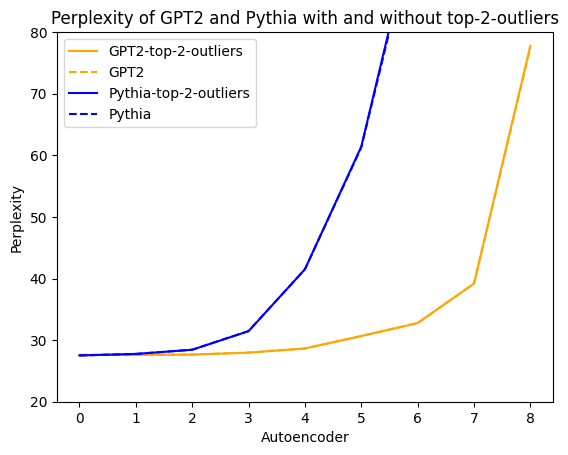

In [40]:
#Plot the pythia perplexities & gpts
plt.plot(all_model_perplexities2[0], label="GPT2-top-2-outliers", color="orange")
plt.plot(all_model_perplexities[0], label="GPT2", linestyle="--", color="orange")
plt.plot(all_model_perplexities2[1], label="Pythia-top-2-outliers", color="blue")
plt.plot(all_model_perplexities[1], label="Pythia", linestyle="--", color="blue")
plt.legend()
plt.title("Perplexity of GPT2 and Pythia with and without top-2-outliers")
plt.xlabel("Autoencoder")
plt.ylabel("Perplexity")
plt.ylim(20, 80)
plt.show()

In [30]:
model_perplexity_diff

array([[-1.67083740e-03,  2.05039978e-03,  6.40869141e-04,
         1.07574463e-03, -2.60925293e-03,  4.00543213e-03,
        -4.59289551e-03, -1.39236450e-03, -2.84675598e-01],
       [-4.90188599e-04,  7.83538818e-03,  1.17053986e-02,
         1.84993744e-02, -2.21633911e-03, -1.29508972e-01,
        -8.25691223e-01,  3.09411621e+00,  5.08766113e+02]])

In [24]:
all_model_perplexities # 0

[array([27.59947968, 27.61652374, 27.64967537, 27.97204018, 28.64097404,
        30.66466331, 32.76556015, 39.17483521, 77.51404572]),
 array([  27.50660706,   27.76299477,   28.44542885,   31.47120667,
          41.49584579,   61.27206421,   98.97418976,  303.42489624,
        4692.35351562])]

In [20]:
all_model_perplexities # 1

[array([27.59962654, 27.61610031, 27.64871979, 27.9709053 , 28.63993073,
        30.66494179, 32.76259995, 39.17511368, 77.8780365 ]),
 array([  27.50711823,   27.75564194,   28.44044304,   31.42954636,
          41.33651352,   61.02084732,   98.85749817,  294.18612671,
        4537.15478516])]

In [18]:
all_model_perplexities # 2

[array([27.60115051, 27.61447334, 27.6490345 , 27.97096443, 28.6435833 ,
        30.66065788, 32.77015305, 39.17622757, 77.79872131]),
 array([  27.50709724,   27.75515938,   28.43372345,   31.45270729,
          41.49806213,   61.40157318,   99.79988098,  300.33078003,
        4183.58740234])]

In [22]:
all_model_perplexities# 10

[array([27.59186172, 27.61104393, 27.64015579, 27.89469147, 28.61002541,
        30.1843586 , 31.86545753, 35.27019119, 55.05447388]),
 array([  27.50718307,   27.75325966,   28.41473007,   31.3962326 ,
          41.19856262,   60.96576309,   97.82530212,  288.10852051,
        3631.71118164])]

In [ ]:
outlier_dims = find_outliers(dataset, cache_name, model, num_outlier_dims=2)


# Load Dictionaries

In [ ]:
#Change these settings to load the correct autoencoder
layer = 2
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)
# filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun5/autoencoders.pkl"
# filename = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
# filename = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun3/autoencoders.pkl"
# filename = "/home/mchorse/logan_sparse_coding/sparse_coding/ae2.pkl"


if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError


# Load the pickle file
with open(filename, 'rb') as file:
    autoencoders = pickle.load(file)

# Index for l1 value, usually only 1 value is available
l1_index = -1
dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[l1_index]]
for d in dictionaries:
    print(d.shape)
print("len of autoencoders: ", len(autoencoders))

dict_index = 0
smaller_dict, larger_dict = dictionaries[dict_index], dictionaries[dict_index+1]
smaller_auto_encoder, larger_auto_encoder = autoencoders[l1_index][dict_index], autoencoders[l1_index][dict_index+1]

In [ ]:
import torch
from transformer_lens import HookedTransformer
from torch import nn
import pickle
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from einops import rearrange
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_sweep_tied_mlpout_l1_r8/_9/learned_dicts.pt"
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_sweep_tied_mlpout_l2_r4/_19/learned_dicts.pt"
# autoencoder_filename = "/home/mchorse/sparse_coding_hoagy/tiedlong_tied_residual_l5_r4/_10/learned_dicts.pt"
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_hoagy_dense_sweep_tied_residual_l4_r6/_99/learned_dicts.pt"
# autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_hoagy_dense_sweep_tied_residual_l4_r6/_0/learned_dicts.pt"
layer = 4

autoencoder_filename = "/home/mchorse/logan/sparse_coding/output_hoagy_dense_sweep_tied_residual_l4_r6/_0/learned_dicts.pt"
auto_num = 0 # Selects which specific autoencoder to use
all_autoencoders = torch.load(autoencoder_filename)
num_dictionaries = len(all_autoencoders)
print(f"Loaded {num_dictionaries} autoencoders")
autoencoder, hyperparams = all_autoencoders[auto_num]
l1_alpha = hyperparams['l1_alpha']
# autoencoder2, hyperparams2 = all_autoencoders[auto_num+1]
smaller_dict = autoencoder.get_learned_dict()
# larger_dict = autoencoder2.get_learned_dict()

#Change these settings to load the correct autoencoder
setting = "residual"
# setting = "attention"
# setting = "mlp"
# setting = "mlp_out"
model_name = "EleutherAI/pythia-70m-deduped"
# model_name = "EleutherAI/pythia-160m"

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
elif setting == "attention":
    cache_name = f"blocks.{layer}.hook_attn_out"
    neurons = model.cfg.d_model
elif setting == "mlp_out":
    cache_name = f"blocks.{layer}.hook_mlp_out"
    neurons = model.cfg.d_model
else:
    raise NotImplementedError

In [ ]:
from transformer_lens import HookedTransformer
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from einops import rearrange
layer = 2
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError


# MCS
Max cosine similarity between one dictionary & another one. If they learned the same feature, then they'll have high cosine similarity. 

If two dictionaries learned it, it's probably a real feature.

# Model activations & Dictionary Activations

In [ ]:
# Downnload dataset
dataset_name = "NeelNanda/pile-10k"
token_amount= 256
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

In [ ]:
all_autoencoders

In [ ]:
from functools import partial

def mlp_ablation_hook(value, hook, autoencoder):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    return reconstruction
n_chunks = 12
chunk_size = 2
l1_values = [1e-3, 9e-4, 8e-4, 7e-4]
all_perplexities = np.zeros(4, (n_chunks//chunk_size))
for chunk_trained in range(0,12,2): 
    autoencoder_filename = f"/home/mchorse/logan/sparse_coding/output_hoagy_dense_sweep_tied_residual_l4_r6/_{chunk_trained}/learned_dicts.pt"
    all_autoencoders = torch.load(autoencoder_filename)
    model = model.eval()
    batch_size = 128
    num_dictionaries = len(all_autoencoders)
    l1_perplexity = np.zeros(num_dictionaries + 1)
    all_l1s = np.zeros(num_dictionaries + 1)
    for l1_index in range(len(all_autoencoders)):
        # print(f"L1 index: {l1_index}")
        autoencoder, hyperparams = all_autoencoders[l1_index]
        autoencoder.to_device(device)
        print(hyperparams)
        # for dict_index in range(num_dictionaries + 1):
        #     if(dict_index != num_dictionaries):
        #         autoencoder, hyperparams = all_autoencoders[dict_index]
        #         autoencoder.to_device(device)
        #         print(hyperparams)
        #     else:
        #         continue
        total_loss = 0
        total_tokens = 0
        with torch.no_grad(), dataset.formatted_as("pt"):
            dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
            for i, batch in enumerate(dl):
                # Get model predictions
                if(l1_index == num_dictionaries): # Full model
                    loss = model(batch.to(device), return_type="loss")
                else:
                    loss = model.run_with_hooks(batch.to(device), 
                        return_type="loss",
                        fwd_hooks=[(
                            cache_name, 
                            partial(mlp_ablation_hook, autoencoder=autoencoder),
                            )]
                        )
                total_loss += loss.item()
        # Average
        avg_neg_log_likelihood = total_loss / len(dl)

        # Convert to tensor
        avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

        # Exponentiate to compute perplexity
        perplexity = torch.exp(avg_neg_log_likelihood)
        if(l1_index == num_dictionaries):
            print("Perplexity for full model: ", perplexity.item())
            original_perplexity = perplexity.item()
        else:
            # print(f"Perplexity for dict_size={dictionaries[dict_index].shape[0]}: {perplexity.item():.2f}")
            print(f"{perplexity.item():.2f}")
        # l1_perplexity[l1_index] = perplexity.item()
        all_perplexities[chunk_trained, l1_index] = perplexity.item()

In [ ]:
all_autoencoders[0]

In [ ]:
from functools import partial

def mlp_ablation_hook(value, hook, autoencoder):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    return reconstruction

model = model.eval()
batch_size = 128
# for l1_index in range(len(autoencoders)):
#     print(f"L1 index: {l1_index}")
#     all_autoencoders = autoencoders[l1_index]
all_autoencoders = all_autoencoders[3:]
num_dictionaries = len(all_autoencoders)
all_perplexities = np.zeros(num_dictionaries + 1)
all_l1s = np.zeros(num_dictionaries + 1)
for dict_index in range(num_dictionaries + 1):
    if(dict_index != num_dictionaries):
        autoencoder, hyperparams = all_autoencoders[dict_index]
        autoencoder.to_device(device)
        print(hyperparams)
    else:
        continue
    total_loss = 0
    total_tokens = 0
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            # Get model predictions
            if(dict_index == num_dictionaries): # Full model
                loss = model(batch.to(device), return_type="loss")
            else:
                loss = model.run_with_hooks(batch.to(device), 
                    return_type="loss",
                    fwd_hooks=[(
                        cache_name, 
                        partial(mlp_ablation_hook, autoencoder=autoencoder),
                        )]
                    )
            total_loss += loss.item()
    # Average
    avg_neg_log_likelihood = total_loss / len(dl)

    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

    # Exponentiate to compute perplexity
    perplexity = torch.exp(avg_neg_log_likelihood)
    if(dict_index == num_dictionaries):
        print("Perplexity for full model: ", perplexity.item())
        original_perplexity = perplexity.item()
    else:
        # print(f"Perplexity for dict_size={dictionaries[dict_index].shape[0]}: {perplexity.item():.2f}")
        print(f"{perplexity.item():.2f}")
    all_perplexities[dict_index] = perplexity.item()

In [ ]:
'''
Run_9                                   Run_5 (~converged on reconstruction loss. This is check connection between recon & perplexity and MMCS & perplexity)      
Perplexity for full model:  25.12
L1 index: 0 (3e-3)                                Sparsity
Perplexity for dict_size=2048: 169.76   176.08    24
Perplexity for dict_size=4096: 138.02   171.45    26
Perplexity for dict_size=8192: 127.86   124.92    26
L1 index: 1 (1e-3)
Perplexity for dict_size=2048: 59.14    59.96    73
Perplexity for dict_size=4096: 53.14    55.28    72
Perplexity for dict_size=8192: 51.90    51.16    71
L1 index: 2 (8e-4)
Perplexity for dict_size=2048: 48.80    48.25    96
Perplexity for dict_size=4096: 47.09    45.67    95
Perplexity for dict_size=8192: 55.75    44.87    93

L1 index: 3 (6e-4)                      Run_3 (converged on reconstruction loss)
Perplexity for dict_size=2048: 41.49    39.21    127
Perplexity for dict_size=4096: 42.53    38.97    127
Perplexity for dict_size=8192: 39.87    39.46    124
L1 index: 4 (4e-4)
Perplexity for dict_size=2048: 30.51    31.06    245
Perplexity for dict_size=4096: 49.06    32.59    197 #NOTE: LOGAN DO A DIFF DICT HERE YOU LOSER
Perplexity for dict_size=8192: 33.24    32.81    181
L1 index: 5 (2e-4)
Perplexity for dict_size=2048: 26.19    26.35    387
Perplexity for dict_size=4096: 26.23    26.27    407
Perplexity for dict_size=8192: 26.27    27.28    377
'''

'''
L1 index   Perplexity  Layer  n_chunks   Size
1e-3            38.8     4      100       3k
1e-3            38.8     4      80        3k
1e-3            38.8     4      60        3k
1e-3            38.3     4      40        3k
1e-3            38.82    4      20        3k
1e-3            50.61    4      1         3k
1e-3            49       4      80        2k
7e-4            38       4      80        2k
'''

In [ ]:
'''
Run_3 (~converged on reconstruction loss. This is check connection between recon & perplexity and MMCS & perplexity)
Run_9
Perplexity for full model:  25.12
L1 index: 0 (3e-3)
L1 index: 1 (1e-3)
L1 index: 2 (8e-4)
L1 index: 3 (6e-4)
Perplexity for dict_size=2048: 41.49
Perplexity for dict_size=4096: 42.53
Perplexity for dict_size=8192: 39.87
L1 index: 4 (4e-4)
Perplexity for dict_size=2048: 30.51
Perplexity for dict_size=4096: 49.06
Perplexity for dict_size=8192: 33.24
L1 index: 5 (2e-4)
Perplexity for dict_size=2048: 26.19
Perplexity for dict_size=4096: 26.23
Perplexity for dict_size=8192: 26.27
'''

In [ ]:
from functools import partial
import torch
from transformer_lens import HookedTransformer
import numpy as np 
from torch import nn
import pickle

def mlp_ablation_hook(value, hook, autoencoder):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    return reconstruction

all_autoencoders = torch.load("/home/mchorse/sparse_coding_aidan_new/output_4_rd_deep/_7/learned_dicts.pt")
num_dictionaries = len(all_autoencoders)
all_perplexities = np.zeros(num_dictionaries + 1)
all_l1s = np.zeros(num_dictionaries + 1)
model = model.eval()
batch_size = 32
for dict_index in range(num_dictionaries + 1):
    autoencoder, hyperparams = all_autoencoders[dict_index]
    l1_alpha = hyperparams['l1_alpha']
    autoencoder.to_device(device)
    total_loss = 0
    total_tokens = 0
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            # Get model predictions
            if(dict_index == num_dictionaries): # Full model
                loss = model(batch.to(device), return_type="loss")
            else:
                loss = model.run_with_hooks(batch.to(device), 
                    return_type="loss",
                    fwd_hooks=[(
                        cache_name, 
                        partial(mlp_ablation_hook, autoencoder=autoencoder),
                        )]
                    )
            total_loss += loss.item()
    # Average
    avg_neg_log_likelihood = total_loss / len(dl)

    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

    # Exponentiate to compute perplexity
    perplexity = torch.exp(avg_neg_log_likelihood)
    if(dict_index == num_dictionaries):
        print("Perplexity for full model: ", perplexity.item())
    else:
        print(f"Perplexity for l1={l1_alpha:.2E}: {perplexity.item():.2f}")
    all_perplexities[dict_index] = perplexity.item()
    all_l1s[dict_index] = l1_alpha

In [ ]:
from functools import partial
from transformer_lens import HookedTransformer
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from einops import rearrange

# Load model
model_name = "EleutherAI/pythia-70m-deduped"
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)
model = model.eval()

# Load autoencoders
all_autoencoders = torch.load("/home/mchorse/sparse_coding_aidan_new/output_4_rd_deep/_7/learned_dicts.pt")
num_dictionaries = len(all_autoencoders)

# Set layer & cache name
layer = 2
setting = "residual"
if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError

# Download dataset
batch_size = 32
dataset_name = "NeelNanda/pile-10k"
token_amount= 256
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

# Define function to replace activations with reconstruction
def replace_with_reconstruction(value, hook, autoencoder):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')
    # Run through the autoencoder
    reconstruction = autoencoder.predict(int_val)
    batch, seq_len, hidden_size = value.shape
    reconstruction = rearrange(reconstruction, '(b s) h -> b s h', b=batch, s=seq_len)
    return reconstruction

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    # Calculate Original Perplexity ie no intervention/no dictionary
    total_loss = 0
    for i, batch in enumerate(dl):
        loss = model(batch.to(device), return_type="loss")
        total_loss += loss.item()
    # Average
    avg_neg_log_likelihood = total_loss / len(dl)
    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)
    # Exponentiate to compute perplexity
    original_perplexity = torch.exp(avg_neg_log_likelihood)
    print("Perplexity for original model: ", original_perplexity.item())

    # Compute perplexity for each dictionary
    all_perplexities = np.zeros(num_dictionaries)
    all_l1s = np.zeros(num_dictionaries)
    # Calculate Perplexity for each dictionary
    for dict_index in range(num_dictionaries):
        autoencoder, hyperparams = all_autoencoders[dict_index]
        l1_alpha = hyperparams['l1_alpha']
        autoencoder.to_device(device)
        total_loss = 0
        for i, batch in enumerate(dl):
            # Perplexity with reconstructed activations
            loss = model.run_with_hooks(batch.to(device), 
                return_type="loss",
                fwd_hooks=[(
                    cache_name, # intermediate activation that we intervene on
                    partial(replace_with_reconstruction, autoencoder=autoencoder), # function to apply to cache_name
                    )]
                )
            total_loss += loss.item()
        # Average
        avg_neg_log_likelihood = total_loss / len(dl)
        # Convert to tensor
        avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)
        # Exponentiate to compute perplexity
        perplexity = torch.exp(avg_neg_log_likelihood)
        print(f"Perplexity for l1={l1_alpha:.2E}: {perplexity.item():.2f}")
        all_perplexities[dict_index] = perplexity.item()
        all_l1s[dict_index] = l1_alpha

In [ ]:
# Plot perplexities against their l1s
import matplotlib.pyplot as plt
plt.scatter(all_l1s, all_perplexities)
plt.xlabel('l1')
plt.ylabel('perplexity')
plt.yscale('log')
plt.title('Pythia-70m Residual Layer 2')
plt.show()

In [ ]:
all_perplexities[:32].min()

In [ ]:
# Plot perplexities against their l1s
N = 15
import matplotlib.pyplot as plt
plt.scatter(all_l1s[:N], all_perplexities[:N])
plt.xlabel('l1')
plt.ylabel('perplexity')
# plt.yscale('log')
plt.title('Pythia-70m Residual Layer 2')
plt.show()

In [ ]:
all_l1s

In [ ]:
all_perplexities.squeeze().shape

In [ ]:
import torch
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange


outlier_dimensions = torch.tensor([216, 117, 437, 341, 215,  58, 477, 113, 265,  41, 145, 298, 61, 359, 355, 290])
outlier_dimensions = torch.tensor([111, 156,  71,  47, 369, 473, 396, 197,  48, 258])
perplexities_individual = torch.zeros(len(outlier_dimensions))
l1_index = 1
num_dictionaries = len(autoencoders[l1_index])
# for dict_index in range(num_dictionaries):
for dict_index in range(len(outlier_dimensions)):
    def ablate_residual_dimension(value, hook):
        # Rearrange to fit autoencoder
        value[:, :, outlier_dimensions[dict_index:dict_index+1]] = 0.0
        return value
    model = model.eval()
    total_loss = 0
    total_tokens = 0
    batch_size = 128
    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(dl):
            # Get model predictions
            loss = model.run_with_hooks(batch.to(device), 
                return_type="loss",
                fwd_hooks=[(
                    cache_name, 
                    ablate_residual_dimension
                    )]
                )
            total_loss += loss.item()

    # Average
    avg_neg_log_likelihood = total_loss / len(dl)

    # Convert to tensor
    avg_neg_log_likelihood = torch.tensor(avg_neg_log_likelihood, device=device)

    # Exponentiate to compute perplexity
    perplexity = torch.exp(avg_neg_log_likelihood)
    print(f"Perplexity for Outlier_dimension={dict_index}: {perplexity.item():.2f}")
    perplexities_individual[dict_index] = perplexity.item()

In [ ]:
# Plot perplexities: y-axis perplexity, x-axis: number of outlier dimensions ablated
# Shift perplexities_individual to the right by 1 & assign it's first value to perplexities[0]
perplexities_new = torch.zeros(len(outlier_dimensions)+1)
perplexities_new[1:] = perplexities_individual
perplexities_new[0] = perplexities[0]


import matplotlib.pyplot as plt
plt.plot(perplexities.cpu().numpy(), label="Cumulative Ablation")
plt.plot(perplexities_new[:-1].cpu().numpy(), label="Individual Ablation")
plt.xlabel("Number of outlier dimensions ablated")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

In [ ]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
# neurons = model.W_in.shape[-1]
neurons = model.cfg.d_model
datapoints = dataset.num_rows
batch_size = 64
neuron_activations = torch.zeros((datapoints*token_amount, neurons))
dictionary_activations = torch.zeros((datapoints*token_amount, smaller_dict_features))
smaller_auto_encoder = smaller_auto_encoder.to(device)

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
        neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
        reconstruction, batched_dictionary_activations = smaller_auto_encoder(batched_neuron_activations)
        dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()

In [ ]:
dictionary_activations[:10000,:].count_nonzero(axis=1).float().mean()

# Feature Activation Analysis

## Useful Functions

In [ ]:
from circuitsvis.activations import text_neuron_activations
# Get the activations for the best dict features
def get_feature_datapoints(feature_index, dictionary_activations, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(model.tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = model.tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list

def get_neuron_activation(token, feature, model, setting="dictionary_basis"):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        neuron_act_batch = cache[cache_name]
        if setting=="dictionary_basis":
            _, act = smaller_auto_encoder(neuron_act_batch)
            return act[0, :, feature].tolist()
        else: # neuron/residual basis
            return neuron_act_batch[0, :, feature].tolist()

def ablate_text(text, feature, model, setting="plot"):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    activation_list = []
    for t in text:
        # Convert text into tokens
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            tokens = model.to_tokens(t, prepend_bos=False)
        else: # t equals tokens
            tokens = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        seq_size = tokens.shape[1]
        if(seq_size == 1): # If the text is a single token, we can't ablate it
            continue
        original = get_neuron_activation(tokens, feature, model)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()
        for i in range(seq_size):
            # Remove the i'th token from the input
            ablated_tokens = torch.cat((tokens[:,:i], tokens[:,i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model)[-1]
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        activation_list += changed_activations.tolist() + [0.0]
    activation_list = torch.tensor(activation_list).reshape(-1,1,1)
    if setting == "plot":
        return text_neuron_activations(tokens=display_text_list, activations=activation_list)
    else:
        return display_text_list, activation_list
def visualize_text(text, feature, model, setting="dictionary_basis", max_activation = None):
    if isinstance(text, str):
        text = [text]
    if isinstance(feature, int):
        feature = [feature]
    display_text_list = []
    act_list = []
    for t in text:
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            token = model.to_tokens(t, prepend_bos=False)
        else: # t are tokens
            token = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        for f in feature:
            display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            act_list += get_neuron_activation(token, f, model, setting) + [0.0]
    act_list = torch.tensor(act_list).reshape(-1,1,1)
    if(max_activation is not None):
        act_list = torch.clamp(act_list, max=max_activation)
    return text_neuron_activations(tokens=display_text_list, activations=act_list)
# Ablate the feature direction of the tokens
# token_list is a list of tokens, convert to tensor of shape (batch_size, seq_len)
from einops import rearrange
def ablate_feature_direction(tokens, feature, model, autoencoder):
    def mlp_ablation_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoder(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        # Subtract value with feature direction*act_of_feature
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), autoencoder.decoder.weight[:, feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name, 
            mlp_ablation_hook
            )]
        )
def add_feature_direction(tokens, feature, model, autoencoder, scalar=1.0):
    def residual_add_hook(value, hook):
        feature_direction = autoencoder.decoder.weight[:, feature].squeeze()
        value += scalar*feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name,
            residual_add_hook
            )]
        )
def ablate_feature_direction_display(text, features=None, setting="true_tokens", verbose=False):

    if features==None:
        features = torch.tensor([best_feature])
    if isinstance(features, int):
        features = torch.tensor([features])
    if isinstance(features, list):
        features = torch.tensor(features)
    if isinstance(text, str):
        text = [text]
    text_list = []
    logit_list = []
    for t in text:
        tokens = model.to_tokens(t, prepend_bos=False)
        with torch.no_grad():
            original_logits = model(tokens).log_softmax(-1).cpu()
            ablated_logits = ablate_feature_direction(tokens, features, model, smaller_auto_encoder).log_softmax(-1).cpu()
        diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
        tokens = tokens.cpu()
        if setting == "true_tokens":
            split_text = model.to_str_tokens(t, prepend_bos=False)
            gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
            # Gather the logits for the true tokens
            diff = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
        elif setting == "max":
            # Negate the diff_logits to see which tokens have the largest effect on the neuron
            val, ind = (-1*diff_logits).max(-1)
            diff = rearrange(val[:, :-1], "b s -> (b s)")
            diff*= -1 # Negate the values gathered
            split_text = model.to_str_tokens(ind, prepend_bos=False)
            gather_tokens = rearrange(ind[:,1:], "1 s -> 1 s 1")
        split_text = split_text[1:] # Remove the first token since we're not predicting it
        if(verbose):
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            orig = rearrange(original_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            ablated = rearrange(ablated_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            logit_list += orig.tolist() + [0.0]
            logit_list += ablated.tolist() + [0.0]
        text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        logit_list += diff.tolist() + [0.0]
    logit_list = torch.tensor(logit_list).reshape(-1,1,1)
    if verbose:
        print(f"Max & Min logit-diff: {logit_list.max().item():.2f} & {logit_list.min().item():.2f}")
    return text_neuron_activations(tokens=text_list, activations=logit_list)
def generate_text(input_text, num_tokens, model, autoencoder, feature, temperature=0.7, setting="add", scalar=1.0):
    # Convert input text to tokens
    input_ids = model.tokenizer.encode(input_text, return_tensors='pt').to(device)

    for _ in range(num_tokens):
        # Generate logits
        with torch.no_grad():
            if(setting=="add"):
                logits = add_feature_direction(input_ids, feature, model, autoencoder, scalar=scalar)
            else:
                logits = model(input_ids)

        # Apply temperature
        logits = logits / temperature

        # Sample from the distribution
        probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
        predicted_token = torch.multinomial(probs, num_samples=1)

        # Append predicted token to input_ids
        input_ids = torch.cat((input_ids, predicted_token), dim=-1)

    # Decode the tokens to text
    output_text = model.tokenizer.decode(input_ids[0])

    return output_text

# Logit Lens
def logit_lens(model, best_feature, smaller_dict, layer):
    with torch.no_grad():
        # There are never-used tokens, which have high norm. We want to ignore these.
        bad_ind = (model.W_U.norm(dim=0) > 20)
        feature_direction = smaller_dict[best_feature].to(device)
        # feature_direction = torch.matmul(feature_direction, model.W_out[layer]) # if MLP
        logits = torch.matmul(feature_direction, model.W_U).cpu()
    # Don't include bad indices
    logits[bad_ind] = -1000
    topk_values, topk_indices = torch.topk(logits, 20)
    top_text = model.to_str_tokens(topk_indices)
    print(f"{top_text}")
    print(topk_values)


# Generate Text
You can use the functions below to find interesting features to then add here to "feature"

In [ ]:
sentence = " for"
temp = 0.7
tokens_to_generate = 20
feature = 10 
scalar = 100.0
# Using the function:
print("Normal:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="normal"))
print("Add:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="add"))

# Feature Search
Type in a sentence & see which features activate 
Note: Some features may be outliers, which will typically show up as high activations for the first word & first period or \n (or high positive bias).

In [ ]:
t = " I do like a"
split_text = model.to_str_tokens(t, prepend_bos=False)
token = model.to_tokens(t, prepend_bos=False)
_, cache = model.run_with_cache(token.to(model.cfg.device))
neuron_act_batch = cache[cache_name]
_, act = smaller_auto_encoder(neuron_act_batch)
v, i = act[0, -1, :].topk(10)

print("Activations:",[round(val,2) for val in v.tolist()])
print("Feature_ids", i.tolist())

# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [ ]:
# N = 5
# best_feature = int(max_indices[N])
best_feature = 1461
print("bias:", smaller_auto_encoder.encoder_bias.detach().cpu().numpy()[best_feature])
print(f"Feature index: {best_feature}")
print(f"MCS: {max_cosine_similarities[best_feature]}")
text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
visualize_text(full_text, best_feature, model)

In [ ]:
ablate_text(text_list, best_feature, model)

In [ ]:
ablate_feature_direction_display(full_text, best_feature)

In [ ]:
logit_lens(model,best_feature, smaller_dict, layer)

In [ ]:
custom_text = [
    " Your text here",
]
visualize_text(custom_text, best_feature, model)

# Data Centric Viewpoint

In [ ]:
# Go through datapoints & see if the features that activate on them make sense.
d_point = 0
# text = tokens_dataset[d_point]
data_ind, sequence_pos = np.unravel_index(d_point, (datapoints, token_amount))
feature_val, feature_ind = dictionary_activations[d_point].topk(10)
data_ind = int(data_ind)
sequence_pos = int(sequence_pos)
full_tok = torch.tensor(dataset[data_ind]["input_ids"])
full_text = []
full_text.append(model.tokenizer.decode(full_tok))
visualize_text(full_text, feature_ind, model)

# Check the neuron/residual basis
When we look at the weights of a feature, we are seeing the literal dimensions from the residual stream/neurons being read from the feature. 

Here I'm visualizing the weight values for the residual stream. If there are outliers, then it's mainly reading from that dimension.

In [ ]:
# Check features non-zero weights in decoder
# Plot a histogram of the weights
max_activation = dictionary_activations[:, best_feature].max()
weights = smaller_dict[best_feature]
plt.hist(weights, bins=100)
plt.show()

In [ ]:
(weights*max_activation).topk(20), (weights*max_activation).topk(20, largest=False).values, (weights*max_activation > 0.2).sum()

# Prepend/Append tokens
We can iterate over all tokens to check which ones activate a feature a lot to more rigorously test a hypothesis on what a feature means.

Note: I'm literately running the model through all 50k tokens prepended to the text here

In [ ]:
def prepend_all_tokens_and_get_feature_activation(model, minimal_activating_example, feature, setting="prepend"):
    tokens = model.to_tokens(minimal_activating_example, prepend_bos=False)

    # Run through every number up to vocab size
    vocab_size = model.cfg.d_vocab
    batch_size = 256*2 # Define your desired batch size

    dollar_feature_activations = torch.zeros(vocab_size)
    for start in range(0, vocab_size, batch_size):
        end = min(start + batch_size, vocab_size)

        token_prep = torch.arange(start, end).to(device)
        token_prep = token_prep.unsqueeze(1)  # Add a dimension for concatenation

        # 1. Prepend to the tokens
        if setting == "prepend":
            tokens_catted = torch.cat((token_prep, tokens.repeat(end - start, 1)), dim=1).long()
        elif setting == "append":
            tokens_catted = torch.cat((tokens.repeat(end - start, 1), token_prep), dim=1).long()
        else:
            raise ValueError(f"Unknown setting: {setting}")

        # 2. Run through the model
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens_catted.to(device))
            neuron_act_batch = cache[cache_name]
            _, act = smaller_auto_encoder(neuron_act_batch)

        # 3. Get the feature
        dollar_feature_activations[start:end] = act[:, -1, feature].cpu().squeeze()

    k = 20
    k_increasing_val, k_increasing_ind = dollar_feature_activations.topk(k)
    k_decreasing_val, k_decreasing_ind = dollar_feature_activations.topk(k, largest=False)
    if(setting == "prepend"):
        print(f"[token]{minimal_activating_example}")
    elif(setting == "append"):
        print(f"{minimal_activating_example}[token]")
    else:
        raise ValueError(f"Unknown setting: {setting}")
    # Print indices converted to tokens
    print(f"Top-{k} increasing: {model.to_str_tokens(k_increasing_ind)}")
    # Print values
    print(f"Top-{k} increasing: {[f'{val:.2f}' for val in k_increasing_val]}")
    print(f"Top-{k} decreasing: {model.to_str_tokens(k_decreasing_ind)}")
    print(f"Top-{k} decreasing: {[f'{val:.2f}' for val in k_decreasing_val]}")
    print(f"Number of 0 activations: {torch.sum(dollar_feature_activations == 0)}")
    if(setting == "prepend"):
        best_text = "".join(model.to_str_tokens(dollar_feature_activations.argmax()) + [minimal_activating_example])
    else:
        best_text = "".join([minimal_activating_example] + model.to_str_tokens(dollar_feature_activations.argmax()))
    return best_text

best_text = ""
for x in range(3):
    # best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

In [ ]:
best_text = ""
for x in range(3):
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")

In [ ]:
prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, "The", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")